<a href="https://colab.research.google.com/github/maryamdarei/CNN/blob/main/NEW_CNN_from_github%2C_with_GRADCAM_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It iS a package, from Githup:


"""
CNN trained on a small imagenet dataset
Imagenette is a subset of 10 easily classified classes from 
Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).
https://github.com/fastai/imagenette
Download the Imagenette dataset from Github to Imageneet folder
"""


https://github.com/alexcpn/cnn_train



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/MyDrive/Model Data/Logs

/content/drive/MyDrive/Model Data/Logs


In [ ]:
!tar xzvf imagenette2-320.tgz

In [11]:
!pip install models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached models-0.9.3.tar.gz (16 kB)
  Using cached models-0.9.2.tar.gz (16 kB)
  Using cached models-0.9.1.tar.gz (16 kB)
  Using cached models-0.9.0.tar.gz (14 kB)
  Using cached models-0.8.0.tar.gz (14 kB)
  Using cached models-0.7.0.tar.gz (14 kB)
  Using cached models-0.4.0.tar.gz (11 kB)
  Using cached models-0.3.0.tar.gz (11 kB)
  Using cached models-0.2.0.tar.gz (11 kB)
  Using cached models-0.1.1.tar.gz (11 kB)
  Using cached models-0.1.0.tar.gz (11 kB)
  Using cached models-0.0.5.tar.gz (6.4 kB)
  Using cached models-0.0.4.tar.gz (6.1 kB)
  Using cached models-0.0.3.tar.gz (6.2 kB)
ERROR: Could not find a version that satisfies the requirement models (from versions: 0.0.3, 0.0.4, 0.0.5, 0.1.0, 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.9.3)
ERROR: No matching distribution found for models


In [7]:

import logging as log
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import ticker
#I commented this:
#from models import alexnet, mycnn, mycnn2, resnet
from torch.utils.tensorboard import SummaryWriter


In [9]:
!pwd

/content/drive/MyDrive/Model Data/Logs


In [16]:

log.basicConfig(format="%(asctime)s %(message)s", level=log.INFO)
log.info("======= starting to log ========")
torch.cuda.empty_cache()

In [ ]:
#change the log code
log.basicConfig(filename="/content/drive/MyDrive/Model Data/Logs/logs.log",format="%(asctime)s %(message)s", level=log.INFO)
log.info("======= starting to log ========")
torch.cuda.empty_cache()

In [17]:
!cat /drive/MyDrive/Model Data/Logs/logs.log

cat: /drive/MyDrive/Model: No such file or directory
cat: Data/Logs/logs.log: No such file or directory


In [18]:

# Define relevant variables for the ML task
num_classes = 10
learning_rate = 0.001
num_epochs = 20  # actual 20 epochs
workers = 0
pin_memory = False
batch_size = 64
#I commented these:
#torch.cuda.empty_cache()
#torch.cuda.reset_max_memory_allocated()
#torch.cuda.synchronize()


In [19]:

# Device will determine whether to run the training on GPU or CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    deviceid = torch.cuda.current_device()
    log.info(f"Gpu device {torch.cuda.get_device_name(deviceid)}")


-------------------------------------------------------------------------------------------------------
# Select the model you want to train
-------------------------------------------------------------------------------------------------------



In [20]:
modelname = "alexnet_"

if modelname == "mycnn_":
    # Actual image size is 432*320
    model = mycnn.MyCNN().to(device)
    resize_to = transforms.Resize((227, 227))
if modelname == "mycnn2_":
    # Actual image size is 432*320
    model = mycnn2.MyCNN2().to(device)
    resize_to = transforms.Resize((227, 227))
#if modelname == "alexnet_":
    # Alexnet model works well for CIFAR-10 when input is scaled to 227x227
    model = alexnet.AlexNet().to(device)
    resize_to = transforms.Resize((227, 227))

if modelname == "RestNet50_":
    model = resnet.ResNet50(img_channel=3, num_classes=10).to(device)
    # resizing lower to keep it in memory
    resize_to = transforms.Resize((227, 227))

In [21]:
import os
from PIL import Image

def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r


if __name__ == "__main__":
    paths = list_files("imagenette2-320/val/dogs50A-val")
    problem_files =[]
    for path in paths:
        with open(path, 'rb') as file:
            try:
                img = Image.open(file).load()
            except Exception as e:
                print(e)
                print(path)
                problem_files.append(path)


In [23]:

# -------------------------------------------------------------------------------------------------------
# Load the data from image folder
# -------------------------------------------------------------------------------------------------------

data_dir = "/content/drive/MyDrive/Model Data/imagenette/imagenette2-320"
train_dir = os.path.join(data_dir, "train")
normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

# I changed the code for resize the image:
train_transforms = transforms.Compose(
    [
        
        transforms.Resize((277,277)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(0.5),
        transforms.ToTensor(),
        normalize_transform,
    ]
)

val_dir = os.path.join(data_dir, "val")

val_transforms = transforms.Compose(
    [transforms.Resize((277,277)), transforms.ToTensor(), normalize_transform]
)


train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)


In [24]:

# -----------------------------------------------------------------------------------------------------
# Order the categories as per how Dataloader loads it
# -----------------------------------------------------------------------------------------------------

foldername_to_class = {
    "n02102040": "dog",
    "n01440764": "tench",
    "n02979186": "cassette player",
    "n03000684": "chain saw",
    "n03028079": "church",
    "n03394916": "French horn",
    "n03417042": "garbage truck",
    "n03425413": "gas pump",
    "n03445777": "golf ball",
    "n03888257": "parachute",
}


In [33]:
# sort as value to fit the directory order to labels to be sure
print("Image to Folder Index", train_dataset.class_to_idx)
sorted_vals = dict(sorted(train_dataset.class_to_idx.items(), key=lambda item: item[1]))
categories = []
for key in sorted_vals:
    classname = foldername_to_class[key]
    categories.append(classname)

log.info(f"Categories {categories}")



Image to Folder Index {'n01440764': 0, 'n02102040': 1, 'n02979186': 2, 'n03000684': 3, 'n03028079': 4, 'n03394916': 5, 'n03417042': 6, 'n03425413': 7, 'n03445777': 8, 'n03888257': 9}


In [25]:
# -------------------------------------------------------------------------------------------------------
# Initialise the data loaders
# -------------------------------------------------------------------------------------------------------



# ImageFile.LOAD_TRUNCATED_IMAGES = True # Use the data_checker.py and remove bad files instead of using this

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # IMPORTANT otherwise the data is not shuffled
    num_workers=workers,
    pin_memory=pin_memory,
    sampler=None,
)

test_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=pin_memory,
)



In [26]:
#I added this line for running the model:
model = torchvision.models.resnet50()
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:

# initialize our optimizer and loss function
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
lossFn = nn.CrossEntropyLoss()



In [28]:

# -------------------------------------------------------------------------------------------------------
# Train the model
# -------------------------------------------------------------------------------------------------------

for images, labels in train_loader:
    log.info(f"Shape of X [N, C, H, W]: {images.shape}")
    log.info(f"Shape of y: {labels.shape} {labels.dtype}")
    # test one flow
    # pred = model(x)
    # loss = lossFn(pred, y)
    break
total_step = len(train_loader)
log.info(f"Total steps: {total_step}")

stepsize = total_step // 100
if stepsize < 10:
    stepsize = 10


In [30]:

# Write training matrics to Tensorboard
writer = SummaryWriter()

# loop over our epochs
for epoch in range(0, num_epochs):
    # set the model in training mode
    model.train()  # IMPORTANT otherwise the model is not in training mode
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainAccuracy = 0
    totalTrainAccuracy = 0
    valCorrect = 0

    # loop over the training set
    for i, (images, labels) in enumerate(train_loader):

        try:
            # Train in auto-mode with 16 bit mode
            # with torch.autocast(device_type='cuda', dtype=torch.float16):
            # Train in normal mode
            with torch.autocast(device_type="cuda", dtype=torch.float32):
                # send the input to the device
                (images, labels) = (images.to(device), labels.to(device))
                # perform a forward pass and calculate the training loss
                outputs = model(images)
                # output is float16 because linear layers autocast to float16.
                # assert outputs.dtype is torch.float16 or 64

                loss = lossFn(outputs, labels)
                # zero out the gradients, perform the backpropagation step,
                # and update the weights
                writer.add_scalar("Loss/train", loss,  (epoch * total_step)+(i+1))
                opt.zero_grad()  # IMPORTANT otherwise the gradients of previous batches are not zeroed out
        except Exception as e:
            log.error(f"Exception in data processing- skip and continue = {e}")
        loss.backward()
        totalTrainLoss += loss
        opt.step()
        # Get the predicted values
        _, predicted = torch.max(outputs.data, 1)
        trainAccuracy = (predicted == labels).float().sum().item()
        trainAccuracy = 100 * trainAccuracy / labels.size(0)
        writer.add_scalar("Accuracy/train", trainAccuracy,(epoch * total_step)+(i+1))
        totalTrainAccuracy += trainAccuracy
        # if (i // stepsize) % 10 == 0:
        log.info(
            "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} Accuracy: {:.4f}".format(
                epoch + 1, num_epochs, i + 1, total_step, loss, trainAccuracy
            )
        )

    

    avgTrainLoss = totalTrainLoss / len(train_loader)
    avgAccuracy = totalTrainAccuracy / len(train_loader)
    log.info(
        "--->Epoch [{}/{}], Average Loss: {:.4f} Average Accuracy: {:.4f}".format(
            epoch + 1, num_epochs, avgTrainLoss, avgAccuracy
        )
    )

    print('Epoch [{}/{}], Loss: {:.4f}, TrainAccuracy: {:.4f}, averageloss: {:.4f}, averageacc: {:.4f} '.format(epoch+1, num_epochs, loss, trainAccuracy, avgTrainLoss, avgAccuracy))

    # End Epoch loop
writer.flush()



Epoch [1/20], Loss: 1.3860, TrainAccuracy: 60.6557, averageloss: 1.4497, averageacc: 51.8034 
Epoch [2/20], Loss: 0.8543, TrainAccuracy: 73.7705, averageloss: 1.2265, averageacc: 59.7995 
Epoch [3/20], Loss: 1.0099, TrainAccuracy: 68.8525, averageloss: 1.0942, averageacc: 64.3905 
Epoch [4/20], Loss: 0.8686, TrainAccuracy: 72.1311, averageloss: 1.0238, averageacc: 67.0098 
Epoch [5/20], Loss: 0.8936, TrainAccuracy: 70.4918, averageloss: 0.9356, averageacc: 69.5536 
Epoch [6/20], Loss: 0.9409, TrainAccuracy: 65.5738, averageloss: 0.8667, averageacc: 71.7796 
Epoch [7/20], Loss: 0.6046, TrainAccuracy: 83.6066, averageloss: 0.8063, averageacc: 73.9391 
Epoch [8/20], Loss: 0.6112, TrainAccuracy: 78.6885, averageloss: 0.7523, averageacc: 75.5528 
Epoch [9/20], Loss: 0.6616, TrainAccuracy: 72.1311, averageloss: 0.7209, averageacc: 76.6909 
Epoch [10/20], Loss: 0.6847, TrainAccuracy: 78.6885, averageloss: 0.6643, averageacc: 78.4033 
Epoch [11/20], Loss: 0.5495, TrainAccuracy: 81.9672, averag

In [31]:

# Save the model
path = "/content/drive/MyDrive/Model Data/saved_models"
model_save_name = path + modelname + datetime.now().strftime("%H:%M_%B%d%Y")
torch.save(model.state_dict(), model_save_name + ".pth")
log.info(f"Model {modelname} saved as {model_save_name}")



['tench', 'dog', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
	326.0	5.0	10.0	13.0	6.0	0.0	1.0	0.0	19.0	7.0	tench
	7.0	350.0	6.0	15.0	1.0	0.0	1.0	2.0	5.0	8.0	dog
	3.0	2.0	277.0	18.0	3.0	1.0	7.0	31.0	13.0	2.0	cassette player
	19.0	28.0	10.0	243.0	10.0	2.0	11.0	10.0	26.0	27.0	chain saw
	4.0	2.0	6.0	8.0	354.0	0.0	3.0	14.0	7.0	11.0	church
	10.0	21.0	18.0	60.0	13.0	177.0	35.0	23.0	16.0	21.0	French horn
	2.0	5.0	14.0	16.0	12.0	0.0	287.0	34.0	6.0	13.0	garbage truck
	2.0	5.0	28.0	22.0	16.0	0.0	10.0	321.0	6.0	9.0	gas pump
	12.0	6.0	40.0	7.0	8.0	0.0	2.0	2.0	304.0	18.0	golf ball
	6.0	8.0	3.0	7.0	8.0	0.0	2.0	4.0	18.0	334.0	parachute
---------------------------------------
Accuracy/precision from confusion matrix is 0.76
---------------------------------------
---Accuracy for class tench = 0.84
---Accuracy for class dog = 0.89
---Accuracy for class cassette player = 0.78
---Accuracy for class chain saw = 0.63
---Accuracy for class c

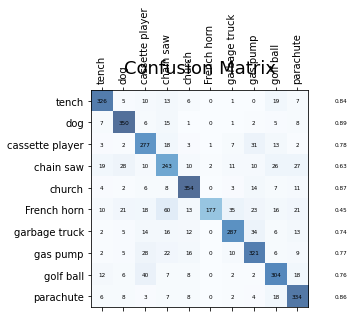

In [34]:
# Generate the Confusion Matrix

confusion_matrix = np.zeros((len(categories), len(categories)))

# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    model.eval()  # IMPORTANT set model to eval mode before inference

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # ------------------------------------------------------------------------------------------
        # Predict for the batch of images
        # ------------------------------------------------------------------------------------------
        outputs = model(
            images
        )  # Outputs= torch.Size([64, 10]) Probability of each of the 10 classes
        _, predicted = torch.max(
            outputs.data, 1
        )  # get the class with the highest Probability out Given 1 per image # predicted= torch.Size([64])
        # ------------------------------------------------------------------------------------------
        #  Lets check also which classes are wrongly predicted with other classes  to create a MultiClass confusion matrix
        # ------------------------------------------------------------------------------------------

        mask = predicted != labels  # Wrongly predicted
        wrong_predicted = torch.masked_select(predicted, mask)
        wrong_labels = torch.masked_select(labels, mask)
        wrongly_zipped = zip(wrong_labels, wrong_predicted)

        mask = predicted == labels  # Rightly predicted
        rightly_predicted = torch.masked_select(predicted, mask)
        right_labels = rightly_predicted  # same torch.masked_select(labels,mask)
        rightly_zipped = zip(right_labels, rightly_predicted)

        # Note that this is for a single batch - add to the list associated with class
        for _, j in enumerate(wrongly_zipped):
            k = j[0].item()  # label
            l = j[1].item()  # predicted
            confusion_matrix[k][l] += 1

        # Note that this is for a single batch - add to the list associated with class
        for _, j in enumerate(rightly_zipped):
            k = j[0].item()  # label
            l = j[1].item()  # predicted
            confusion_matrix[k][l] += 1

    # print("Confusion Matrix1=\n",confusion_matrix)
    # ------------------------------------------------------------------------------------------
    # Print Confusion matrix in Pretty print format
    # ------------------------------------------------------------------------------------------
    print(categories)
    for i in range(len(categories)):
        for j in range(len(categories)):
            print(f"\t{confusion_matrix[i][j]}", end="")
        print(f"\t{categories[i]}\n", end="")
    # ------------------------------------------------------------------------------------------
    # Calculate Accuracy per class
    # ------------------------------------------------------------------------------------------
    print("---------------------------------------")
    print(
        f"Accuracy/precision from confusion matrix is {round(confusion_matrix.trace()/confusion_matrix.sum(),2)}"
    )
    print("---------------------------------------")
    for i in range(len(categories)):
        print(
            f"---Accuracy for class {categories[i]} = {round(confusion_matrix[i][i]/confusion_matrix[i].sum(),2)}"
        )

    # ---------------------------------------------------
    # Plot this in a good figure
    # ---------------------------------------------------

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title("Confusion Matrix", fontsize=18)
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.7)
    ax.set_xticklabels([""] + categories, rotation=90)
    ax.set_yticklabels([""] + categories)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(
                x=j,
                y=i,
                s=int(confusion_matrix[i, j]),
                va="center",
                ha="center",
                size="xx-small",
            )
            if i == j:
                acc = round(confusion_matrix[i][i] / confusion_matrix[i].sum(), 2)
                ax.text(
                    x=len(categories) + 1,
                    y=i,
                    s=acc,
                    va="center",
                    ha="center",
                    size="xx-small",
                )
    plt.savefig(model_save_name + "_cm.jpg")

    # correct = 0
    # total = 0
    # for images, labels in train_loader:
    #     images = images.to(device)
    #     labels = labels.to(device)
    #     outputs = model(images)
    #     _, predicted = torch.max(outputs.data, 1)
    #     total += labels.size(0)
    #     correct += (predicted == labels).float().sum().item()
    # # this is not really not needed- but just to cross check if what we calculated during training is accurate
    # print(
    #     "Accuracy of the network on the {} Train images: {} %".format(
    #         total, 100 * correct / total
    #     )
    # )


"""
Pre trained  model from tutorial modified from
https://pytorch.org/hub/pytorch_vision_alexnet/
And for imagenette small dataset
Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).
https://github.com/fastai/imagenette
Load the Pre-trained models generated from test4_cnn_imagenet_small.py in the same folder
"""

In [35]:

from importlib.resources import path
from PIL import Image
from torchvision import transforms,datasets
import torch
#from models import resnet, alexnet, mycnn, mycnn2
import os


In [37]:
!pwd

/content/drive/MyDrive/Model Data/Logs


In [42]:

test_images = ['test-tench.jpg','fish_boy.jpg','test-church.jpg','test-garbagetruck.jpg','test-truck.jpg','test-dog.jpg','train_dog.png',
"test-englishspringer.jpg","test_dogcartoon.jpg","test_chaingsaw.jpg","test_chainsawtrain.jpg","test_frenchhorn.jpg",
"test_frenchhorntrain.jpg","test-golfball.jpg"]

##/content/drive/MyDrive/Model Data/test-images
#/content/drive/MyDrive/Model Data/imagenette/imagenette2-320/train

data_dir = "../test-images"
train_dir = os.path.join(data_dir, "../imagenette/imagenette2-320/train")
train_dataset = datasets.ImageFolder(train_dir,[])


In [45]:
#-----------------------------------------------------------------------------------------------------
# Order the categories as per how Dataloader loads it
#-----------------------------------------------------------------------------------------------------

foldername_to_class = { 'n02102040' : "dog",
                        'n01440764': "tench",
                        'n02979186': "cassette player", 
                        'n03000684': "chain saw",
                        'n03028079': "church",
                        'n03394916': "French horn",
                        'n03417042': "garbage truck",
                        'n03425413': "gas pump",
                        'n03445777':  "golf ball",
                        'n03888257': "parachute" }

In [46]:
# sort as value to fit the directory order to labels to be sure
print("Image to Folder Index",train_dataset.class_to_idx)
sorted_vals = dict(sorted(train_dataset.class_to_idx.items(), key=lambda item: item[1]))
categories =[]
for key in sorted_vals:
    classname = foldername_to_class[key]
    categories.append(classname)

print("Categories",categories)

Image to Folder Index {'n01440764': 0, 'n02102040': 1, 'n02979186': 2, 'n03000684': 3, 'n03028079': 4, 'n03394916': 5, 'n03417042': 6, 'n03425413': 7, 'n03445777': 8, 'n03888257': 9}
Categories ['tench', 'dog', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


In [52]:

# Choose a saved Model - assign the name you want to test with
# (assuming that you have trained the models)
## I commented this:
#modelname = "resnet50"

#if modelname == "mycnn":
 #   model = mycnn.MyCNN()
  #  path = "mycnn_18:07_October142022.pth" 
  #  resize_to = transforms.Resize((227, 227))
#if modelname == "mycnn2":
 #   model = mycnn2.MyCNN2()
  #  path ="mycnn2_16:43_October182022.pth"
   # resize_to = transforms.Resize((227, 227))
#if modelname == "alexnet":
 #   model = alexnet.AlexNet()
  #  path = "alexnet_15:08_August082022.pth"
  #  resize_to = transforms.Resize((227, 227))
#if modelname == "resnet50":
 #   model = resnet.ResNet50(img_channel=3, num_classes=10)
 #   path ="RestNet50_11:45_November072022.pth"
 #   resize_to = transforms.Resize((227, 227))

#path = "cnn/saved_models/" +path
resize_to = transforms.Resize((227, 227))
#model.load_state_dict(torch.load(path))
model.eval()

for filename in test_images:
    input_image = Image.open('../test-images/'+filename)
    preprocess = transforms.Compose(
        [
            resize_to,
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),  # IMPORTANT: normalize for pretrained models
        ]
    )
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to("cuda")
        model.to("cuda")

    with torch.no_grad():
        output = model(input_batch)
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    # print(probabilities)
    print(f"Detecting for class {filename} model {modelname}")
    print("--------------------------------")
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 2)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
    print("--------------------------------")

Detecting for class test-tench.jpg model resnet50
--------------------------------
tench 1.0
parachute 2.272248877943639e-08
--------------------------------
Detecting for class fish_boy.jpg model resnet50
--------------------------------
tench 0.9134923219680786
golf ball 0.08605096489191055
--------------------------------
Detecting for class test-church.jpg model resnet50
--------------------------------
church 0.9713032245635986
garbage truck 0.02119547314941883
--------------------------------
Detecting for class test-garbagetruck.jpg model resnet50
--------------------------------
garbage truck 0.9934582114219666
golf ball 0.0031143142841756344
--------------------------------
Detecting for class test-truck.jpg model resnet50
--------------------------------
tench 0.6761359572410583
garbage truck 0.3192801773548126
--------------------------------
Detecting for class test-dog.jpg model resnet50
--------------------------------
dog 0.9888808727264404
golf ball 0.01111255120486021


**Utility to check Precision and Recall of a  trained model Author - Alex Punnen**

In [54]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import logging as log
#from models import resnet, alexnet, mycnn, mycnn2
import os
import sklearn.metrics as skmc #this has confusion matrix but need to give all in a shot ?


In [55]:
log.basicConfig(format="%(asctime)s %(message)s", level=log.INFO)
torch.cuda.empty_cache()

In [56]:

# Device will determine whether to run the training on GPU or CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    deviceid = torch.cuda.current_device()
    log.info(f"Gpu device {torch.cuda.get_device_name(deviceid)}")


In [57]:


# Choose a saved Model - assign the name you want to test with
# (assuming that you have trained the models)
# I commented this:
#modelname = "resnet50"
    
#if modelname == "mycnn":
#    model = mycnn.MyCNN()
#    path =  "mycnn_11:49_October302022.pth" 
#    resize_to = transforms.Resize((150, 150))
#if modelname == "mycnn2":
#    model = mycnn2.MyCNN2()
#    path ="mycnn2_16:43_October182022.pth"
#    resize_to = transforms.Resize((227, 227))
#if modelname == "alexnet":
#    model = alexnet.AlexNet()
#    path = "./alexnet_15:08_August082022.pth"
#    resize_to = transforms.Resize((227, 227))
#if modelname == "resnet50":
#    model = resnet.ResNet50(img_channel=3, num_classes=10)
#    path = "./RestNet50_11:43_October072022.pth"   # trained with more dog images from imagenet
#    path ="./RestNet50_11:45_November072022.pth"
#    resize_to = transforms.Resize((227, 227))

#path = "cnn/saved_models/" +path
#model.load_state_dict(torch.load(path))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [59]:
# -------------------------------------------------------------------------------------------------------
# Load the data from image folder
# -------------------------------------------------------------------------------------------------------
#/content/drive/MyDrive/Model Data/imagenette/imagenette2-320
data_dir = "../imagenette/imagenette2-320"


train_dir = os.path.join(data_dir, "train")
normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)


train_transforms = transforms.Compose(
    [resize_to, 
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(),
    transforms.ToTensor(), normalize_transform]
)

val_dir = os.path.join(data_dir, "val")

val_transforms = transforms.Compose(
    [resize_to, transforms.ToTensor(), normalize_transform]
)


train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)

val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)


In [62]:
#-----------------------------------------------------------------------------------------------------
# Order the categories as per how Dataloader loads it
#-----------------------------------------------------------------------------------------------------

foldername_to_class = { 'n02102040' : "dog",
                        'n01440764': "tench",
                        'n02979186': "cassette player", 
                        'n03000684': "chain saw",
                        'n03028079': "church",
                        'n03394916': "French horn",
                        'n03417042': "garbage truck",
                        'n03425413': "gas pump",
                        'n03445777':  "golf ball",
                        'n03888257': "parachute" }

# Imagenette classes - labels for better description
categories_ref = [
    "English springer",
    "tench",
    "cassette player",
    "chain saw",
    "church",
    "French horn",
    "garbage truck",
    "gas pump",
    "golf ball",
    "parachute",
]


In [63]:
# sort as value to fit the directory order to labels to be sure
print("Image to Folder Index",train_dataset.class_to_idx)
sorted_vals = dict(sorted(train_dataset.class_to_idx.items(), key=lambda item: item[1]))
categories =[]
for key in sorted_vals:
    classname = foldername_to_class[key]
    categories.append(classname)

print("Categories",categories)


Image to Folder Index {'n01440764': 0, 'n02102040': 1, 'n02979186': 2, 'n03000684': 3, 'n03028079': 4, 'n03394916': 5, 'n03417042': 6, 'n03425413': 7, 'n03445777': 8, 'n03888257': 9}
Categories ['tench', 'dog', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


In [64]:
# -------------------------------------------------------------------------------------------------------
# Initialise the data loaders
# -------------------------------------------------------------------------------------------------------

workers = 2
pin_memory = True
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True, #IMPORTANT otherwise the data is not shuffled
    num_workers=workers,
    pin_memory=pin_memory,
    sampler=None,
)

test_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=pin_memory,
)

Image to Folder Index {'n01440764': 0, 'n02102040': 1, 'n02979186': 2, 'n03000684': 3, 'n03028079': 4, 'n03394916': 5, 'n03417042': 6, 'n03425413': 7, 'n03445777': 8, 'n03888257': 9}
['tench', 'dog', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
	315.0	1.0	3.0	1.0	1.0	0.0	1.0	0.0	17.0	48.0	tench
	71.0	274.0	2.0	0.0	1.0	0.0	0.0	1.0	12.0	34.0	dog
	48.0	12.0	108.0	1.0	2.0	0.0	7.0	1.0	125.0	53.0	cassette player
	114.0	27.0	5.0	7.0	7.0	0.0	11.0	0.0	95.0	120.0	chain saw
	57.0	5.0	14.0	4.0	240.0	0.0	23.0	0.0	17.0	49.0	church
	62.0	41.0	9.0	5.0	8.0	0.0	6.0	0.0	31.0	232.0	French horn
	158.0	4.0	22.0	2.0	2.0	0.0	124.0	0.0	30.0	47.0	garbage truck
	60.0	11.0	103.0	0.0	13.0	0.0	64.0	8.0	93.0	67.0	gas pump
	50.0	6.0	13.0	1.0	2.0	0.0	0.0	0.0	260.0	67.0	golf ball
	52.0	4.0	0.0	0.0	3.0	0.0	1.0	0.0	33.0	297.0	parachute
---------------------------------------
Accuracy/precision from confusion matrix is 0.42
--------------------------------

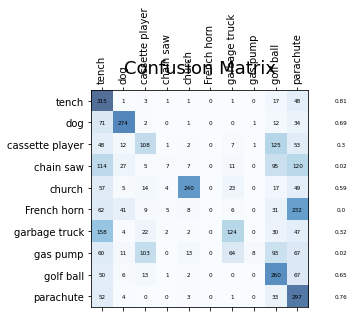

In [65]:
# -------------------------------------------------------------------------------------------------------
#  Test the model - Find accuracy and per class
# -------------------------------------------------------------------------------------------------------

print("Image to Folder Index",train_dataset.class_to_idx)

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    model.to("cuda")

confusion_matrix = np.zeros((len(categories),len(categories)))

# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    model.eval() #IMPORTANT set model to eval mode before inference
    # correct = 0
    # total = 0


    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # ------------------------------------------------------------------------------------------
        # Predict for the batch of images
        # ------------------------------------------------------------------------------------------
        outputs = model(images)  #Outputs= torch.Size([64, 10]) Probability of each of the 10 classes
        _, predicted = torch.max(outputs.data, 1) # get the class with the highest Probability out Given 1 per image # predicted= torch.Size([64])
        # total += labels.size(0) #labels= torch.Size([64])  This is the truth value per image - the right class
        # correct += (predicted == labels).float().sum().item()  # Find which are correctly classified
        
        # Below illustrates the above Torch Tensor semantics
        # >>> import torch
        # >>> some_integers = torch.tensor((2, 3, 5, 7, 11, 13, 17, 19))
        # >>> some_integers3 = torch.tensor((12, 3, 5, 7, 11, 13, 17, 19))
        # >>> (some_integers ==some_integers3)*(some_integers == 3)
        # tensor([False,  True, False, False, False, False, False, False])
        # >>> ((some_integers ==some_integers3)*(some_integers >12)).sum().item()
        # 3
        
        # ------------------------------------------------------------------------------------------
        #  Lets check also which classes are wrongly predicted with other classes  to create a MultiClass confusion matrix
        # ------------------------------------------------------------------------------------------

        mask=(predicted != labels) # Wrongly predicted
        wrong_predicted =torch.masked_select(predicted,mask)
        wrong_labels =torch.masked_select(labels,mask)
        wrongly_zipped = zip(wrong_labels,wrong_predicted)

        mask=(predicted == labels) # Rightly predicted
        rightly_predicted =torch.masked_select(predicted,mask)
        right_labels =rightly_predicted #same torch.masked_select(labels,mask)
        rightly_zipped = zip(right_labels,rightly_predicted)
        
        # Note that this is for a single batch - add to the list associated with class
        for _,j in enumerate(wrongly_zipped):
            k = j[0].item() # label
            l = j[1].item() # predicted
            confusion_matrix[k][l] +=1
       
        # Note that this is for a single batch - add to the list associated with class
        for _,j in enumerate(rightly_zipped):
            k = j[0].item() # label
            l = j[1].item() # predicted
            confusion_matrix[k][l] +=1
    
    #print("Confusion Matrix1=\n",confusion_matrix)
    # ------------------------------------------------------------------------------------------
    # Print Confusion matrix in Pretty print format
    # ------------------------------------------------------------------------------------------
    print(categories)
    for i in range(len(categories)):
        for j in range(len(categories)):
            print(f"\t{confusion_matrix[i][j]}",end='')
        print(f"\t{categories[i]}\n",end='')
    # ------------------------------------------------------------------------------------------
    # Calculate Accuracy per class
    # ------------------------------------------------------------------------------------------
    print("---------------------------------------")
    print(f"Accuracy/precision from confusion matrix is {round(confusion_matrix.trace()/confusion_matrix.sum(),2)}")
    print("---------------------------------------")
    for i in range(len(categories)):
        print(f"---Accuracy for class {categories[i]} = {round(confusion_matrix[i][i]/confusion_matrix[i].sum(),2)}")
    
    # ---------------------------------------------------
    # Plot this in a good figure
    # ---------------------------------------------------
        

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title('Confusion Matrix', fontsize=18)
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.7)
    ax.set_xticklabels([''] + categories,rotation=90)
    ax.set_yticklabels([''] + categories)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(x=j, y=i,s=int(confusion_matrix[i, j]), va='center', ha='center', size='xx-small')
            if ( i==j):
                acc = round(confusion_matrix[i][i]/confusion_matrix[i].sum(),2)
                ax.text(x=len(categories)+1, y=i,s=acc, va='center', ha='center', size='xx-small')
    plt.savefig("confusion_matrix_"+modelname +".jpg")

    # correct = 0
    # total = 0
    # for images, labels in train_loader:
    #     images = images.to(device)
    #     labels = labels.to(device)
    #     outputs = model(images)
    #     _, predicted = torch.max(outputs.data, 1)
    #     total += labels.size(0)
    #     correct += (predicted == labels).float().sum().item()
    # # this is not really not needed- but just to cross check if what we calculated during training is accurate
    # print(
    #     "Accuracy of the network on the {} Train images: {} %".format(
    #         total, 100 * correct / total
    #     )
    # )



***Model Explain-ability GradCam***
Gradcam helps one visualize which parts of the images are important for the CNN when it classifies an object with high probability. After testing a model, you can use this to visualize and debug the test results

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


Using Grad CAM libray to visualize the gradients of the last layer
and to see if the model has learned the features of the images

In [74]:
!pip install grad_cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=af00c3c86da9b15586876eab3f175c2ef4916b39e500ed629c9d450d849ae52d
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [75]:
from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad,
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


from importlib.resources import path
from PIL import Image
from torchvision import transforms, datasets
import torch
#from models import resnet, alexnet, mycnn, mycnn2
import numpy as np
import os
import torch.nn as nn

In [76]:
#-----------------------------------------------------------------------------------------------------
# Order the categories as per how Dataloader loads it
#-----------------------------------------------------------------------------------------------------
#/content/drive/MyDrive/Model Data/imagenette/imagenette2-320

data_dir = "../imagenette/imagenette2-320"
train_dir = os.path.join(data_dir, "train")
train_dataset = datasets.ImageFolder(train_dir,[])

foldername_to_class = { 'n02102040' : "dog",
                        'n01440764': "tench",
                        'n02979186': "cassette player", 
                        'n03000684': "chain saw",
                        'n03028079': "church",
                        'n03394916': "French horn",
                        'n03417042': "garbage truck",
                        'n03425413': "gas pump",
                        'n03445777':  "golf ball",
                        'n03888257': "parachute" }


# sort as value to fit the directory order to labels to be sure
print("Image to Folder Index",train_dataset.class_to_idx)
sorted_vals = dict(sorted(train_dataset.class_to_idx.items(), key=lambda item: item[1]))
categories =[]
for key in sorted_vals:
    classname = foldername_to_class[key]
    categories.append(classname)

print("Categories",categories)


Image to Folder Index {'n01440764': 0, 'n02102040': 1, 'n02979186': 2, 'n03000684': 3, 'n03028079': 4, 'n03394916': 5, 'n03417042': 6, 'n03425413': 7, 'n03445777': 8, 'n03888257': 9}
Categories ['tench', 'dog', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


In [79]:
# Choose a saved Model - comment out the rest
# I commented this:
#modelname = "resnet50"

# Choose a saved Model - assign the name you want to test with
# (assuming that you have trained the models)
#modelname = "resnet50"
#resize_size =(1,1)
#if modelname == "mycnn":
#    resize_size = (227, 227)
#    model = mycnn.MyCNN()
#    path = "mycnn_18:07_October142022.pth"
#    path ="mycnn_13:01_October272022.pth" #dual class only
#    resize_to = transforms.Resize(resize_size)
#if modelname == "mycnn2":
#    resize_size = (227, 227)
#    model = mycnn2.MyCNN2()
#    path ="mycnn2_16:43_October182022.pth"
#    resize_to = transforms.Resize(resize_size)
#if modelname == "alexnet":
#    resize_size = (227,227)
#    model = alexnet.AlexNet()
#    path = "alexnet_20:56_October102022.pth"
#    resize_to = transforms.Resize(resize_size)
#if modelname == "resnet50":
#    model = resnet.ResNet50(img_channel=3, num_classes=10)
#    resize_size =(227,227)
    #path = "./RestNet50_12:26_August082022.pth" # without augumentation
#    path = "RestNet50_13:49_September102022.pth" #with augumentation
#    path = "RestNet50_16:54_October062022.pth" #with cartoon dogs
#    path = "RestNet50_11:43_October072022.pth"   # trained with more dog images from imagenet
#    path ="RestNet50_11:45_November072022.pth" #227*227
   # resize_to = transforms.Resize(227,227)

#path = "cnn/saved_models/" +path
#model.load_state_dict(torch.load(path))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [80]:

def flatten_model(modules):
    def flatten_list(_2d_list):
        flat_list = []
        # Iterate through the outer list
        for element in _2d_list:
            if type(element) is list:
                # If the element is of type list, iterate through the sublist
                for item in element:
                    flat_list.append(item)
            else:
                flat_list.append(element)
        return flat_list

    ret = []
    try:
        for _, n in modules:
            ret.append(loopthrough(n))
    except:
        try:
            if str(modules._modules.items()) == "odict_items([])":
                ret.append(modules)
            else:
                for _, n in modules._modules.items():
                    ret.append(loopthrough(n))
        except:
            ret.append(modules)
    return flatten_list(ret)




In [81]:
# Set the target for the CAM layer; Add all the layers in the model
target_layers =[]
module_list =[module for module in model.modules()]


flatted_list= flatten_model(module_list)


print("------------------------")
for count, value in enumerate(flatted_list):
    
    if isinstance(value, (nn.Conv2d,nn.AvgPool2d,nn.BatchNorm2d)):
    #if isinstance(value, (nn.Conv2d)):
        print(count, value)
        target_layers.append(value)

print("------------------------")


------------------------
1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
2 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
7 Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
8 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
9 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
10 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
11 Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
12 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
15 Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
16 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
18 Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
19 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
20 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [82]:
# Alternative is to add specific layers and check
# if modelname=='resnet50':
#     #target_layers = [module_list[142],module_list[143],module_list[144],module_list[145],module_list[146],module_list[147]]
#     target_layers = [module_list[35],module_list[36],module_list[37],module_list[38],module_list[39],module_list[40]]
# if modelname=='mycnn':
#     target_layers = [module_list[11],module_list[8],module_list[5],module_list[2],module_list[4],module_list[7],module_list[10],module_list[13]] # CNN and Avg pooling
#     #target_layers = [module_list[11],module_list[8],module_list[5],module_list[2]] # CNN only

    
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)



In [85]:
# Load the images
#/content/drive/MyDrive/Model Data/test-images

resize_size =(227,227)

test_images = ['test-tench.jpg','fish_boy.jpg','test-church.jpg','test-garbagetruck.jpg','test-truck.jpg','test-dog.jpg','train_dog.png',
"test-englishspringer.jpg","test_dogcartoon.jpg","test_chaingsaw.jpg","test_chainsawtrain.jpg","test_frenchhorn.jpg",
"test_frenchhorntrain.jpg","test-golfball.jpg"]

for filename in test_images:
    input_image = Image.open('../test-images/'+filename)

    preprocess = transforms.Compose(
        [
            resize_to,
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),  # IMPORTANT: normalize for pre-trained models
        ]
    )
    input_tensor = preprocess(input_image)
    print("Input Tensor Shape:", input_tensor.shape)
    input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to("cuda")
        model.to("cuda")
        input_tensor = input_tensor.to("cuda")

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category
    # will be used for every image in the batch.
    # Here we use ClassifierOutputTarget, but you can define your own custom targets

    # That are, for example, combinations of categories, or specific outputs in a non standard model.
    targets = [ClassifierOutputTarget(6)] #0 for finch ?

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_batch, targets=None,aug_smooth=True)
    #print( "len grayscale_cam",len(grayscale_cam),grayscale_cam.shape)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    # from PIL import Image
    # im = Image.fromarray(grayscale_cam)
    # if im.mode != 'RGB':
    #     im = im.convert('L')
    # im.save("grayscale_cam.jpeg"

#/content/drive/MyDrive/Model Data/gradcam_out

    img=np.array(input_image.resize(resize_size),np.float32)
    img = img.reshape(img.shape[1],img.shape[0],img.shape[2])
    #print("img shape",img.shape,img.max())
    img = img/255
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    #cam_images = [show_cam_on_image(img, grayscale, use_rgb=True) for img, grayscale in zip(input_image, grayscale_cam)]
    visualization = Image.fromarray(visualization)
    out_file_name ="../gradcam_out/" +modelname+ "_" + os.path.basename(filename)
    visualization.save(out_file_name)
    #print("Visualization saved- now trying to show (GUI mode)")
    im = Image.open(out_file_name)
    im.show()
    



Input Tensor Shape: torch.Size([3, 227, 227])
Input Tensor Shape: torch.Size([3, 227, 227])
Input Tensor Shape: torch.Size([3, 227, 227])
Input Tensor Shape: torch.Size([3, 227, 227])
Input Tensor Shape: torch.Size([3, 227, 227])
Input Tensor Shape: torch.Size([3, 227, 227])
Input Tensor Shape: torch.Size([3, 227, 227])
Input Tensor Shape: torch.Size([3, 227, 227])
Input Tensor Shape: torch.Size([3, 227, 227])
Input Tensor Shape: torch.Size([3, 227, 227])
Input Tensor Shape: torch.Size([3, 227, 227])
Input Tensor Shape: torch.Size([3, 227, 227])
Input Tensor Shape: torch.Size([3, 227, 227])
Input Tensor Shape: torch.Size([3, 227, 227])
